# Dropout缓解过拟合

当数据较少时容易出现过拟合(overfitting)

In [1]:
%matplotlib

Using matplotlib backend: Qt5Agg


<p>我们在这里搭建两个神经网络, 一个没有 <code class="language-plaintext highlighter-rouge">dropout</code>, 一个有 <code class="language-plaintext highlighter-rouge">dropout</code>. 没有 <code class="language-plaintext highlighter-rouge">dropout</code> 的容易出现 过拟合, 那我们就命名为 <code class="language-plaintext highlighter-rouge">net_overfitting</code>,
另一个就是 <code class="language-plaintext highlighter-rouge">net_dropped</code>. <code class="language-plaintext highlighter-rouge">torch.nn.Dropout(0.5)</code> 这里的 0.5 指的是随机有 50% 的神经元会被关闭/丢弃.</p>

torch.Size([20, 1]) torch.Size([20, 1])


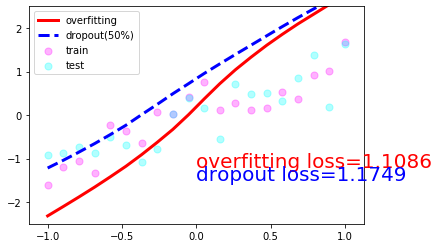

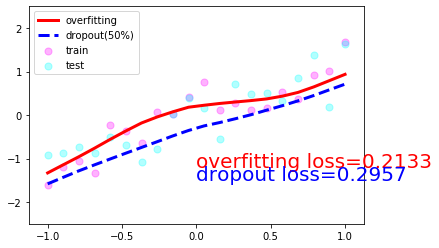

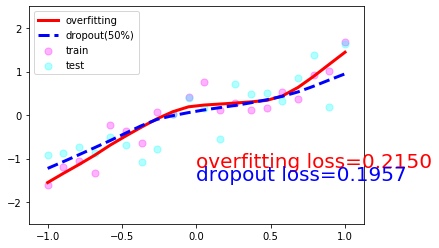

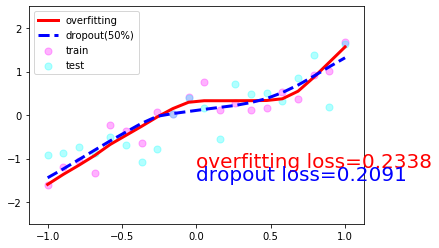

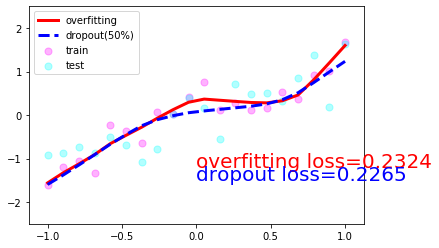

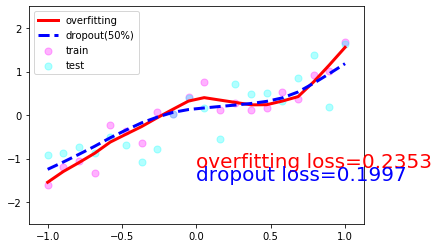

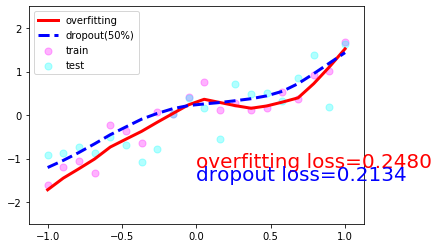

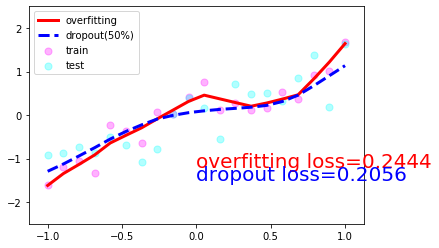

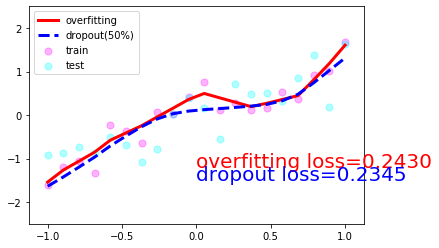

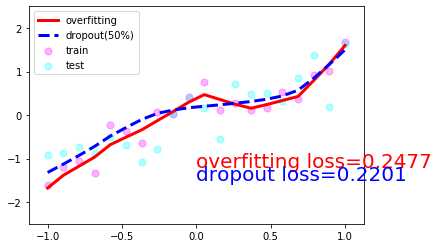

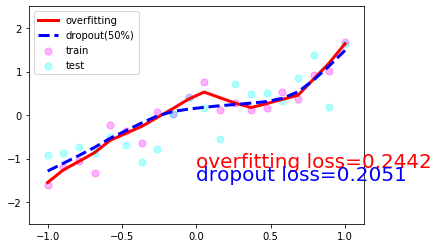

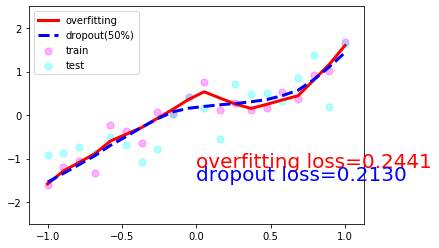

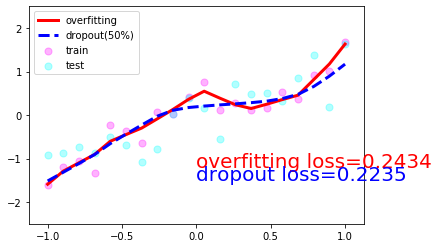

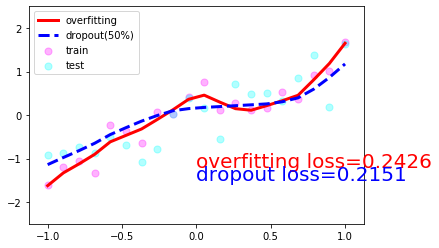

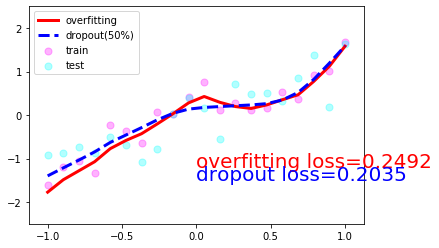

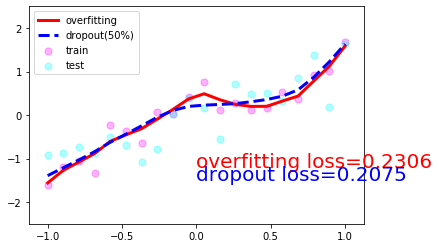

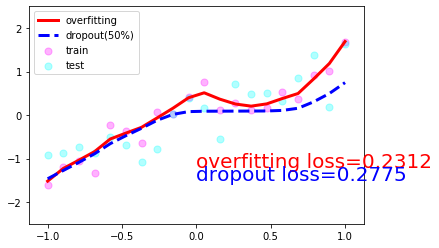

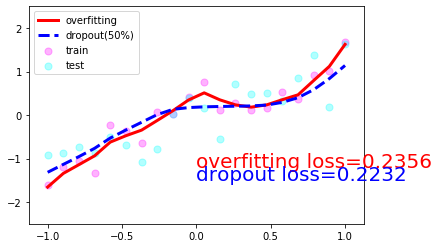

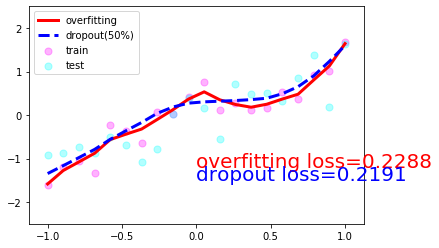

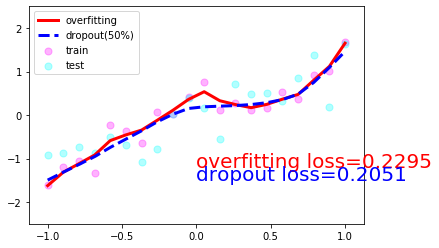

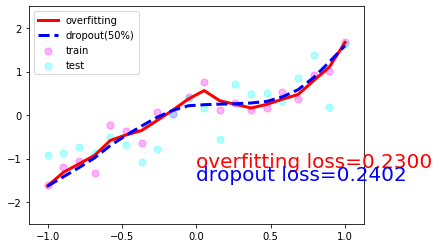

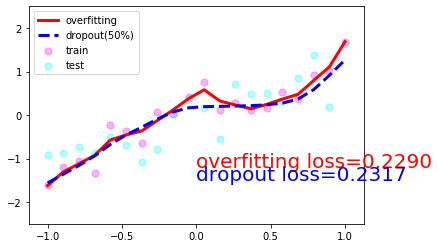

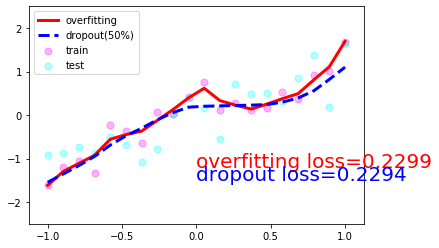

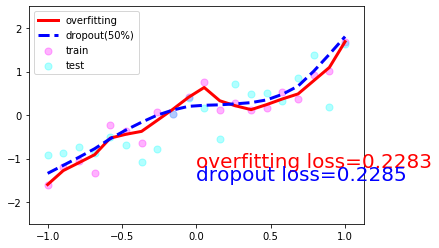

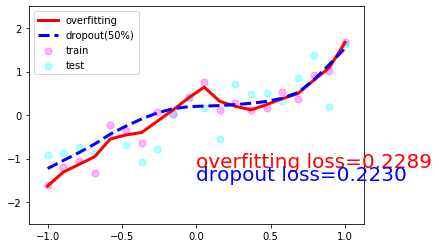

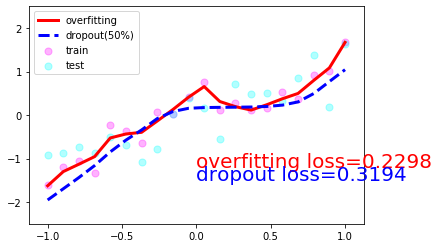

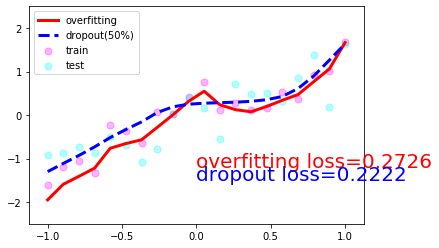

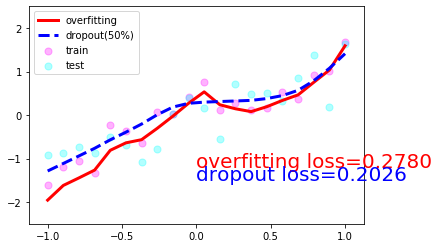

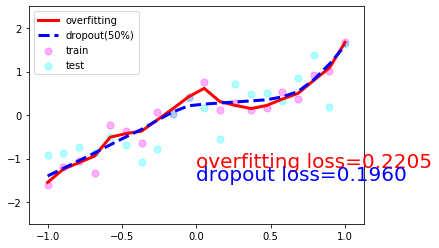

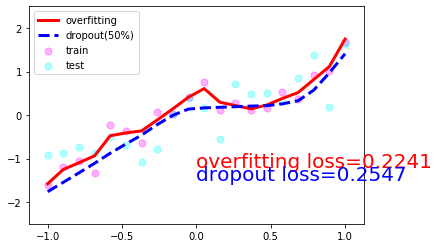

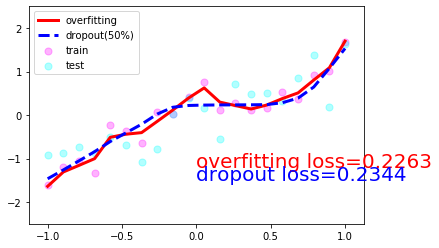

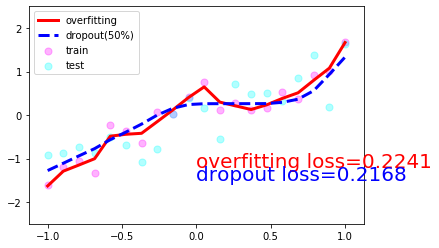

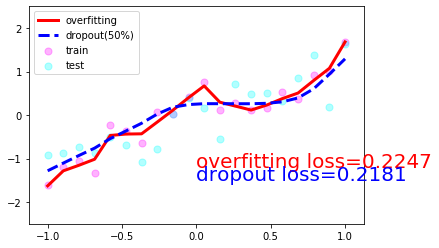

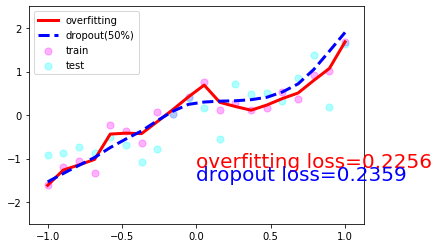

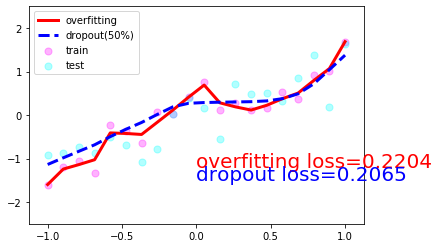

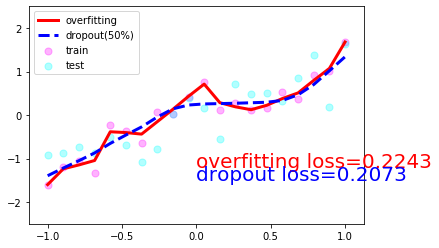

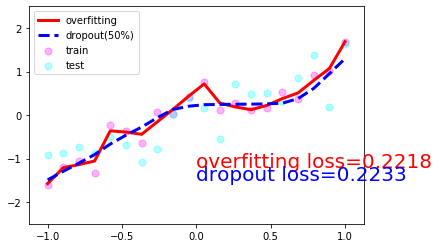

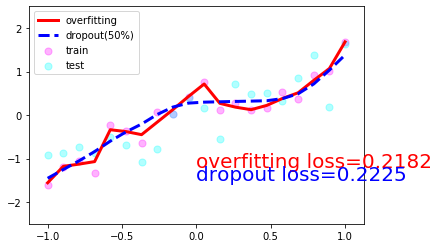

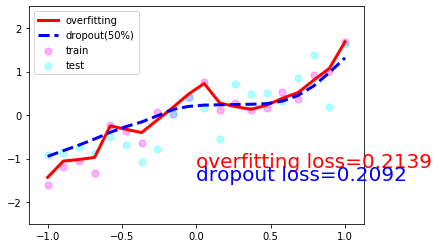

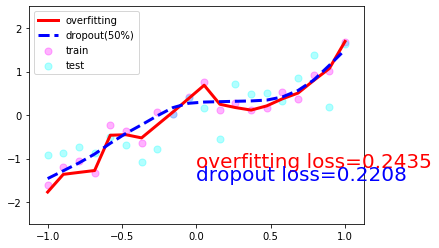

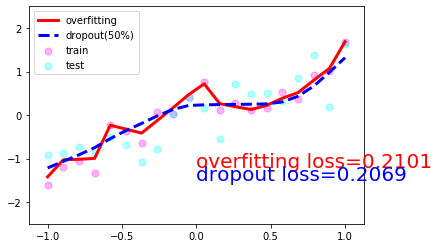

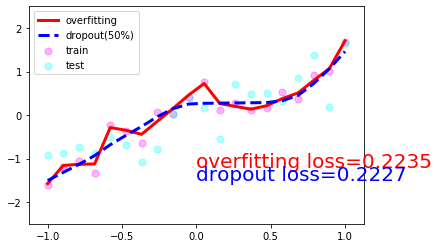

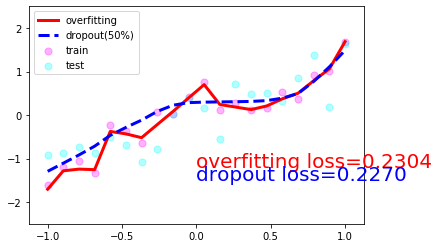

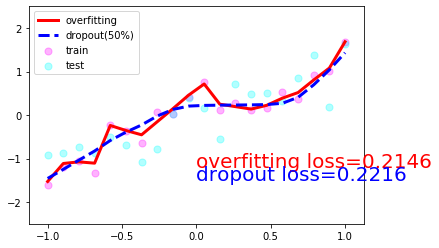

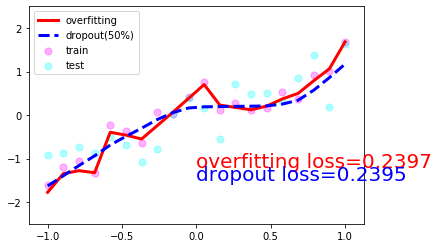

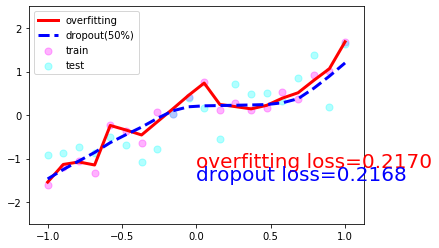

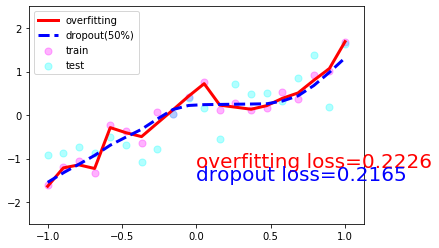

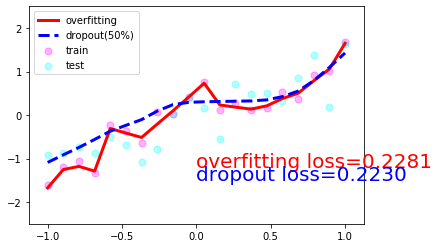

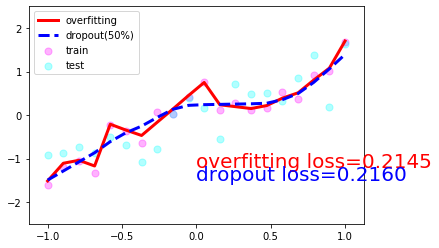

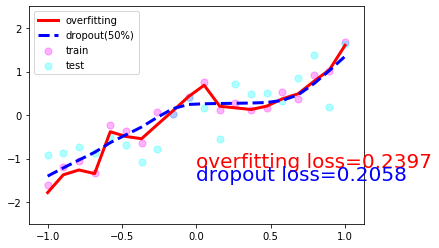

In [4]:
import torch
import matplotlib.pyplot as plt


torch.manual_seed(1)

N_SAMPLES = 20
N_HIDDEN = 300

# training data
x = torch.linspace(-1, 1, N_SAMPLES).reshape((-1, 1))
y = x + 0.4 * torch.randn(N_SAMPLES, 1)
print(x.shape, y.shape)

# test data
x_test = torch.linspace(-1, 1, N_SAMPLES).reshape((-1, 1))
y_test = x + 0.4 * torch.randn(N_SAMPLES, 1)

net_overfitting = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

net_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

# print(net_overfitting, '\n', net_dropout)

optimizer_ofit = torch.optim.Adam(net_overfitting.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(net_dropout.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

plt.ion()

for i in range(500):
    pred_ofit = net_overfitting(x)
    pred_drop = net_dropout(x)
    loss_ofit = loss_func(pred_ofit, y)
    loss_drop = loss_func(pred_drop, y)
    
    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    loss_ofit.backward()
    loss_drop.backward()
    
    optimizer_ofit.step()
    optimizer_drop.step()
    
    if i % 10 == 0:
        # change to eval mode in order to fix drop out effect
        net_overfitting.eval()
        net_dropout.eval()  # parameters for dropout from train mode
        
        # plotting
        plt.cla()
        test_pred_ofit = net_overfitting(x_test)
        test_pred_drop = net_dropout(x_test)
        plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.3, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='cyan', s=50, alpha=0.3, label='test')
        plt.plot(x_test.data.numpy(), test_pred_ofit.data.numpy(), 'r-', lw=3, label='overfitting')
        plt.plot(x_test.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='dropout(50%)')
        plt.text(0, -1.2, 'overfitting loss=%.4f' % loss_func(test_pred_ofit, y_test).data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.text(0, -1.5, 'dropout loss=%.4f' % loss_func(test_pred_drop, y_test).data.numpy(), fontdict={'size': 20, 'color': 'blue'})
        plt.legend(loc='upper left'); plt.ylim((-2.5, 2.5));plt.pause(0.1)
        
        # change back to train mode
        net_dropout.train()
        net_overfitting.train()
        
plt.ioff()
plt.show()

# Batch Normalization 批标准化


In [21]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [33]:
import torch
from torch import nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import sys


torch.manual_seed(1)
np.random.seed(1)

# Hyper parameters
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCH = 12
LR = 0.01
N_HIDDEN = 8
ACTIVATION = torch.nn.functional.sigmoid  # 试试其它：tanh, relu
B_INIT = -0.2  # use a bad bias constant initializer

# training data
x = np.linspace(-7, 10, N_SAMPLES).reshape((-1, 1))
noise = np.random.normal(0, 2, x.shape)
y = np.square(x) - 5 + noise

# test data
test_x = np.linspace(-7, 10, 200).reshape((-1, 1))
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

train_x, train_y = torch.tensor(x).float(), torch.tensor(y).float()
test_x, test_y = torch.tensor(test_x).float(), torch.tensor(test_y).float()

train_dataset = Data.TensorDataset(train_x, train_y)
train_dataloader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                   shuffle=True)

# show data
plt.scatter(train_x, train_y, c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')


class Net(nn.Module):
    def __init__(self, batch_normalization=False):
        super().__init__()
        self.do_bn = batch_normalization  # do batch normalization
        self.fcs = []
        self.bns = []
        self.bn_input = nn.BatchNorm1d(1, momentum=0.5)

        for i in range(N_HIDDEN):
            input_size = 1 if i == 0 else 10
            fc = nn.Linear(input_size, 10)
            setattr(self, 'fc%i' % i, fc)
            self.fcs.append(fc)
            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)
                self.bns.append(bn)

        self.predict = nn.Linear(10, 1)
        self._set_init(self.predict)  
        
    def _set_init(self, layer):
        torch.nn.init.normal_(layer.weight, mean=0., std=.1)
        torch.nn.init.constant_(layer.bias, B_INIT)

    def forward(self, x):
        layer_input = [x]  # store the history of x's input
        pre_activation = [x]  # store the history of x's output
        if self.do_bn: x = self.bn_input(x)
        for i in range(N_HIDDEN):
            x = self.fcs[i](x)
            pre_activation.append(x)
            if self.do_bn: x = self.bns[i](x)
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)

        return out, layer_input, pre_activation


nets = [Net(False), Net(True)]

# print(nets[0], '\n'*2, nets[1])
optimizers = [torch.optim.Adam(net.parameters(), lr=LR) for net in nets]
loss_func = nn.MSELoss()

def plot_histogram(l_in, l_in_bn, pre_ac, pre_ac_bn):
    for i, (ax_pa, ax_pa_bn, ax, ax_bn) in enumerate(zip(axs[0, :], axs[1, :], axs[2, :], axs[3, :])):
        [a.clear() for a in [ax_pa, ax_pa_bn, ax, ax_bn]]
        if i == 0:
            p_range = (-7, 10);the_range = (-7, 10)
        else:
            p_range = (-4, 4);the_range = (-1, 1)
        ax_pa.set_title('L' + str(i))
        ax_pa.hist(pre_ac[i].data.numpy().ravel(), bins=10, range=p_range, color='#FF9359', alpha=0.5);ax_pa_bn.hist(pre_ac_bn[i].data.numpy().ravel(), bins=10, range=p_range, color='#74BCFF', alpha=0.5)
        ax.hist(l_in[i].data.numpy().ravel(), bins=10, range=the_range, color='#FF9359');ax_bn.hist(l_in_bn[i].data.numpy().ravel(), bins=10, range=the_range, color='#74BCFF')
        for a in [ax_pa, ax, ax_pa_bn, ax_bn]: a.set_yticks(());a.set_xticks(())
        ax_pa_bn.set_xticks(p_range);ax_bn.set_xticks(the_range)
        axs[0, 0].set_ylabel('PreAct');axs[1, 0].set_ylabel('BN PreAct');axs[2, 0].set_ylabel('Act');axs[3, 0].set_ylabel('BN Act')
    plt.pause(0.01)

In [34]:
if __name__ == '__main__':
    f, axs = plt.subplots(4, N_HIDDEN + 1, figsize=(10, 5))
    plt.ion()  # something about plotting
    plt.show()
    # training
    losses = [[], []]  # recode loss for two networks

    for epoch in range(EPOCH):
        layer_inputs, pre_acts = [], []
        for net, l in zip(nets, losses):
            net.eval()              # set eval mode to fix moving_mean and moving_var
            pred, layer_input, pre_act = net(test_x)
            l.append(loss_func(pred, test_y).data.item())
            layer_inputs.append(layer_input)
            pre_acts.append(pre_act)
            net.train()             # free moving_mean and moving_var
        plot_histogram(*layer_inputs, *pre_acts)     # plot histogram
        
        for step, (b_x, b_y) in enumerate(train_dataloader):
            for net, opt in zip(nets, optimizers):  # train for each network
                pred, _, _ = net(b_x)
                loss = loss_func(pred, b_y)
                opt.zero_grad()
                loss.backward()
                opt.step()
                
#                 print('epoch:', epoch, '|step:', step, '|loss:', loss.item())
#             print('\n')
    plt.ioff()

    # plot training loss
    plt.figure(2)
    plt.plot(losses[0], c='#FF9359', lw=3, label='Original')
    plt.plot(losses[1], c='#74BCFF', lw=3, label='Batch Normalization')
    plt.xlabel('step');plt.ylabel('test loss');plt.ylim((0, 2000));plt.legend(loc='best')

    # evaluation
    # set net to eval mode to freeze the parameters in batch normalization layers
    [net.eval() for net in nets]    # set eval mode to fix moving_mean and moving_var
    preds = [net(test_x)[0] for net in nets]
    plt.figure(3)
    plt.plot(test_x.data.numpy(), preds[0].data.numpy(), c='#FF9359', lw=4, label='Original')
    plt.plot(test_x.data.numpy(), preds[1].data.numpy(), c='#74BCFF', lw=4, label='Batch Normalization')
    plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='train')
    plt.legend(loc='best')
    plt.show()




C:\D_disk\Anaconda3\envs\my_ml\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\D_disk\Anaconda3\envs\my_ml\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
